<a href="https://colab.research.google.com/github/agi2019/ppi-gci/blob/main/tutorials/03%20-%20simple_prospective.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Simple prospective simulation</center>

Prepared by Omar A. Guerrero (oguerrero@turing.ac.uk, <a href="https://twitter.com/guerrero_oa">@guerrero_oa</a>)

In this tutorial I will demonstrate how to perform simple prospective analysis by simulating the indicators forward 10 years and measuring the development gaps that would remain open. I will also show how to implement some intuitive visualisations.

## Importing Python libraries to manipulate and visualise data

In [1]:
#!pip install dataframe-image
#!pip install dataframe-image playwright
#!playwright install

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import asyncio
import dataframe_image as dfi

In [3]:
#scenario = '_scenario1'
#scenario = '_scenario2'
scenario = '_scenario3'

## Importing PPI functions

In [4]:
import policy_priority_inference as ppi
pd.set_option('display.max_rows', None)

## Load data

Since I am now performing prospective simulations, the initial conditions are the most updated values, i.e. `IF`.

In [5]:
# INDICATORS
df_indis = pd.read_csv('C:/Users/rha005/OneDrive - CSIRO/Documents/7. CSIRO/00. Work in Progress - ON Office/Week 9-10/ppi-gci-main-indicators/tutorials/clean_data'+scenario+'/data_indicators.csv')
N = len(df_indis) # number of indicators
I0 = df_indis.I0.values # initial values
R = df_indis.instrumental # instrumental indicators
qm = df_indis.qm.values # quality of monitoring
rl = df_indis.rl.values # quality of the rule of law
indis_index = dict([(code, i) for i, code in enumerate(df_indis.seriesCode)]) # used to build the network matrix
Imax = df_indis.maxVals.values
Imin = df_indis.minVals.values
B_dict_full = {i: [i] for i in range(N)}
R_full = np.ones(N)
# PARAMETERS
df_params = pd.read_csv('C:/Users/rha005/OneDrive - CSIRO/Documents/7. CSIRO/00. Work in Progress - ON Office/Week 9-10/ppi-gci-main-indicators/tutorials/clean_data'+scenario+'/parameters.csv')
alphas = df_params.alpha.values
alphas_prime = df_params.alpha_prime.values
betas = df_params.beta.values

# NETWORK
df_net = pd.read_csv('C:/Users/rha005/OneDrive - CSIRO/Documents/7. CSIRO/00. Work in Progress - ON Office/Week 9-10/ppi-gci-main-indicators/tutorials/clean_data'+scenario+'/data_network.csv')
#A = np.zeros((N, N)) # adjacency matrix
#for index, row in df_net.iterrows():
#    i = indis_index[row.origin]
#    j = indis_index[row.destination]
#    w = row.weight
#    A[i,j] = w
valid_codes = set(df_indis.index)
df_net = df_net[df_net['origin'].isin(valid_codes)]
df_net = df_net[df_net['destination'].isin(valid_codes)]

A = np.zeros((len(indis_index), len(indis_index)))

for _, row in df_net.iterrows():
    i = indis_index[row['origin']]
    j = indis_index[row['destination']]
    A[i, j] = row['weight']

# DISBURSEMENT SCHEDULE (make sure that the disbursement schedule is consistent with T, otherwise PPI will simulate the T of the calibration)
T = 60 # recall that simulation steps are not equivalente to calendar time (see tutorial 01c - data preparation (expenditure))
T_full = 60
#df_exp = pd.read_csv('C:/Users/rha005/OneDrive - CSIRO/Documents/7. CSIRO/00. Work in Progress - ON Office/Week 9-10/ppi-gci-main-indicators/tutorials/clean_data'+scenario+'/data_expenditure.csv')
df_exp = pd.read_csv('C:/Users/rha005/OneDrive - CSIRO/Documents/7. CSIRO/00. Work in Progress - ON Office/Week 9-10/ppi-gci-main-indicators/tutorials/clean_data'+scenario+'/Bs_2025.csv')
#Bs_retrospective = df_exp.values[:,1::] # disbursement schedule (assumes that the expenditure programmes are properly sorted)
Bs_retrospective = df_exp.drop(columns='seriesCode').values  # shape = (63 x tahun)

# Create a new disbursement schedule assuming that expenditure will be the same as the last period of the sample
# Bs tetap 63 x T
Bs = np.tile(Bs_retrospective[:, -1], (T, 1)).T  # shape: (63, T)

# Build B_dict: key = indeks indikator instrumental, value = [index_in_Bs]
#B_dict = {i: [i] for i in range(len(Bs)) if df_indis['instrumental'].iloc[i] == 1}
# Ambil mask indikator instrumental
instrumental_mask = df_indis['instrumental'].astype(bool).values

# Bangun B_dict hanya untuk indikator instrumental (jumlah = 56)
B_dict = {i: [i] for i in range(len(instrumental_mask)) if instrumental_mask[i]}

# Validasi
assert len(B_dict) == instrumental_mask.sum()   # Harus 56
assert max(p for v in B_dict.values() for p in v) < Bs.shape[0]  # Harus < 63


In [6]:
df_exp

,seriesCode,0,1,2,3,4,5,6,7,8,...,56,57,58,59,60,61,62,63,64,65
0,gci11_Lonline,4.948887e+09,4.948887e+09,4.948887e+09,4.948887e+09,4.948887e+09,4.948887e+09,4.948887e+09,4.948887e+09,4.948887e+09,...,4.948887e+09,4.948887e+09,4.948887e+09,4.948887e+09,4.948887e+09,4.948887e+09,4.948887e+09,4.948887e+09,4.948887e+09,4.948887e+09
1,gci11_Lforgery,3.900000e+07,3.900000e+07,3.900000e+07,3.900000e+07,3.900000e+07,3.900000e+07,3.900000e+07,3.900000e+07,3.900000e+07,...,3.900000e+07,3.900000e+07,3.900000e+07,3.900000e+07,3.900000e+07,3.900000e+07,3.900000e+07,3.900000e+07,3.900000e+07,3.900000e+07
2,gci11_Lolsafety,7.919500e+07,7.919500e+07,7.919500e+07,7.919500e+07,7.919500e+07,7.919500e+07,7.919500e+07,7.919500e+07,7.919500e+07,...,7.919500e+07,7.919500e+07,7.919500e+07,7.919500e+07,7.919500e+07,7.919500e+07,7.919500e+07,7.919500e+07,7.919500e+07,7.919500e+07
3,gci12_Rpdp,4.629170e+08,4.629170e+08,4.629170e+08,4.629170e+08,4.629170e+08,4.629170e+08,4.629170e+08,4.629170e+08,4.629170e+08,...,4.629170e+08,4.629170e+08,4.629170e+08,4.629170e+08,4.629170e+08,4.629170e+08,4.629170e+08,4.629170e+08,4.629170e+08,4.629170e+08
4,gci12_Rprivacy,4.865300e+08,4.865300e+08,4.865300e+08,4.865300e+08,4.865300e+08,4.865300e+08,4.865300e+08,4.865300e+08,4.865300e+08,...,4.865300e+08,4.865300e+08,4.865300e+08,4.865300e+08,4.865300e+08,4.865300e+08,4.865300e+08,4.865300e+08,4.865300e+08,4.865300e+08
5,gci12_Rnotif,8.154980e+08,8.154980e+08,8.154980e+08,8.154980e+08,8.154980e+08,8.154980e+08,8.154980e+08,8.154980e+08,8.154980e+08,...,8.154980e+08,8.154980e+08,8.154980e+08,8.154980e+08,8.154980e+08,8.154980e+08,8.154980e+08,8.154980e+08,8.154980e+08,8.154980e+08
6,gci12_RAuditre,5.617200e+08,5.617200e+08,5.617200e+08,5.617200e+08,5.617200e+08,5.617200e+08,5.617200e+08,5.617200e+08,5.617200e+08,...,5.617200e+08,5.617200e+08,5.617200e+08,5.617200e+08,5.617200e+08,5.617200e+08,5.617200e+08,5.617200e+08,5.617200e+08,5.617200e+08
7,gci12_Rstandard,2.330601e+09,2.330601e+09,2.330601e+09,2.330601e+09,2.330601e+09,2.330601e+09,2.330601e+09,2.330601e+09,2.330601e+09,...,2.330601e+09,2.330601e+09,2.330601e+09,2.330601e+09,2.330601e+09,2.330601e+09,2.330601e+09,2.330601e+09,2.330601e+09,2.330601e+09
8,gci12_Rsign,4.389090e+08,4.389090e+08,4.389090e+08,4.389090e+08,4.389090e+08,4.389090e+08,4.389090e+08,4.389090e+08,4.389090e+08,...,4.389090e+08,4.389090e+08,4.389090e+08,4.389090e+08,4.389090e+08,4.389090e+08,4.389090e+08,4.389090e+08,4.389090e+08,4.389090e+08
9,gci12_Rspam,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [7]:
Bs

array([[4.948887e+09, 4.948887e+09, 4.948887e+09, ..., 4.948887e+09,
        4.948887e+09, 4.948887e+09],
       [3.900000e+07, 3.900000e+07, 3.900000e+07, ..., 3.900000e+07,
        3.900000e+07, 3.900000e+07],
       [7.919500e+07, 7.919500e+07, 7.919500e+07, ..., 7.919500e+07,
        7.919500e+07, 7.919500e+07],
       ...,
       [3.079810e+08, 3.079810e+08, 3.079810e+08, ..., 3.079810e+08,
        3.079810e+08, 3.079810e+08],
       [1.948640e+08, 1.948640e+08, 1.948640e+08, ..., 1.948640e+08,
        1.948640e+08, 1.948640e+08],
       [1.897582e+09, 1.897582e+09, 1.897582e+09, ..., 1.897582e+09,
        1.897582e+09, 1.897582e+09]])

In [8]:
# 1. Ambil indeks program yang digunakan
used_programs = sorted(set(p for v in B_dict.values() for p in v))

# 2. Subset Bs hanya ke program yang digunakan
Bs_used = Bs[used_programs, :]  # shape: (56, T)

# 3. Bangun ulang B_dict agar sesuai dengan Bs_used yang sudah disubset
old2new = {old: new for new, old in enumerate(used_programs)}
B_dict_new = {k: [old2new[v[0]]] for k, v in B_dict.items()}

# 4. Validasi
assert Bs_used.shape[0] == len(set(p for v in B_dict_new.values() for p in v))

In [9]:
Bs_used

array([[4.948887e+09, 4.948887e+09, 4.948887e+09, ..., 4.948887e+09,
        4.948887e+09, 4.948887e+09],
       [3.900000e+07, 3.900000e+07, 3.900000e+07, ..., 3.900000e+07,
        3.900000e+07, 3.900000e+07],
       [7.919500e+07, 7.919500e+07, 7.919500e+07, ..., 7.919500e+07,
        7.919500e+07, 7.919500e+07],
       ...,
       [3.079810e+08, 3.079810e+08, 3.079810e+08, ..., 3.079810e+08,
        3.079810e+08, 3.079810e+08],
       [1.948640e+08, 1.948640e+08, 1.948640e+08, ..., 1.948640e+08,
        1.948640e+08, 1.948640e+08],
       [1.897582e+09, 1.897582e+09, 1.897582e+09, ..., 1.897582e+09,
        1.897582e+09, 1.897582e+09]])

In [10]:
#df_Bsretro = pd.DataFrame(Bs_retrospective)
df_Bs = pd.DataFrame(Bs_used)
# Optional: add indicator index as a column
#df_Bsretro.insert(0, 'indicator_index', range(Bs.shape[0]))
#df_Bs.insert(0, 'indicator_index', range(Bs.shape[0]))
#df_Bsretro.to_csv('C:/Users/rha005/OneDrive - CSIRO/Documents/7. CSIRO/00. Work in Progress - ON Office/Week 9-10/ppi-gci-main-indicators/tutorials/clean_data'+scenario+'/Bs_retro_output.csv', index=False)
df_Bs.to_csv('C:/Users/rha005/OneDrive - CSIRO/Documents/7. CSIRO/00. Work in Progress - ON Office/Week 9-10/ppi-gci-main-indicators/tutorials/clean_data'+scenario+'/Bs_output.csv', index=False)

## Development goals

To measure development gaps, it is necessary to consider the goals that the government has in mind. Here, I establish them by randomly choosing a value between the most recent level of an indicator and its technical upper bound.

In [11]:
goals = Imax

## Simulate

PPI has inherent stochasticity, so a single model run may not be representative of the average output behaviour. I obviated this in the calibration tutorial as much of the simulation sampling is hidden behind the functions. Here, I would like to be more explicit regarding the Monte Carlo sampling procedure, and how to construct the average time series (across simulations) of the indicators. I will use this information to estimate the development gaps that will remain in 10 years.

In this tutorial, I will perform the Monte Carlo simulations in a serial fashion. In other words, I will write an explicit `for` loop that waits for one simulation to finish before beginning a new–independent–one. In the next tutorials, I will use a function that allows me to parallelise this task.

In [12]:
print("Jumlah baris I0:", len(I0))
print("Jumlah baris Imin:", len(Imin))
print("Jumlah baris Imax:", len(Imax))
print("Jumlah indikator instrumental:", R.sum())
print("Jumlah baris Bs:", len(Bs_used))
print("Jumlah baris B_dict:", len(B_dict))

Jumlah baris I0: 63
Jumlah baris Imin: 63
Jumlah baris Imax: 63
Jumlah indikator instrumental: 57
Jumlah baris Bs: 57
Jumlah baris B_dict: 57


In [13]:
sample_size = 100 # number of Monte Carlo simulations

outputs = []
for sample in range(sample_size):
    output = ppi.run_ppi(I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
                Imax=Imax, Imin=Imin, Bs=Bs_used, B_dict=B_dict_new, T=T, G=goals)
    outputs.append(output)

In [14]:
# separate the outputs into lists of time series
tsI, tsC, tsF, tsP, tsS, tsG = zip(*outputs)

# compute the average time series of the indicators
tsI_hat = np.mean(tsI, axis=0)

# make a new DataFrame with the indicators' information
new_rows = []
for i, serie in enumerate(tsI_hat):
    new_row = [df_indis.iloc[i].seriesCode, df_indis.iloc[i].sdg, df_indis.iloc[i].color] + serie.tolist()
    new_rows.append(new_row)

df_output = pd.DataFrame(new_rows, columns=['seriesCode', 'sdg', 'color']+list(range(T)))
df_output['goal'] = goals

In [15]:
df_output

,seriesCode,sdg,color,0,1,2,3,4,5,6,...,51,52,53,54,55,56,57,58,59,goal
0,gci11_Lonline,11,#A21942,0.952941,0.963257,0.973401,0.982089,0.988425,0.991737,0.993746,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,gci11_Lforgery,11,#A21942,0.922925,0.922901,0.922950,0.923037,0.923086,0.923062,0.923075,...,0.925786,0.926020,0.926180,0.926193,0.926242,0.926218,0.926268,0.926318,0.926367,1.0
2,gci11_Lolsafety,11,#A21942,1.000000,0.999949,0.999902,0.999856,0.999814,0.999763,0.999718,...,0.998500,0.998458,0.998415,0.998416,0.998365,0.998339,0.998346,0.998316,0.998292,1.0
3,gci12_Rpdp,12,#FF3A21,0.741936,0.745980,0.751799,0.756619,0.760885,0.764929,0.769971,...,0.944704,0.946679,0.949014,0.951372,0.954172,0.955613,0.956874,0.958212,0.960012,1.0
4,gci12_Rprivacy,12,#FF3A21,0.741936,0.749505,0.757292,0.763881,0.770143,0.776949,0.784083,...,0.983860,0.985287,0.986029,0.986639,0.987043,0.987657,0.988492,0.989408,0.990262,1.0
5,gci12_Rnotif,12,#FF3A21,0.741936,0.756628,0.771015,0.785248,0.799329,0.813715,0.828407,...,0.999988,0.999994,0.999994,1.000000,0.999988,0.999976,0.999976,0.999958,0.999994,1.0
6,gci12_RAuditre,12,#FF3A21,0.741936,0.754871,0.766704,0.778536,0.790644,0.803166,0.815136,...,0.999923,0.999926,0.999917,0.999917,0.999953,0.999961,0.999947,0.999958,0.999950,1.0
7,gci12_Rstandard,12,#FF3A21,0.741936,0.751137,0.760239,0.769242,0.778047,0.787248,0.796151,...,0.998932,0.998940,0.998937,0.999034,0.999031,0.999018,0.999019,0.999124,0.999126,1.0
8,gci12_Rsign,12,#FF3A21,0.741936,0.749875,0.757721,0.765286,0.772569,0.780602,0.788542,...,0.994517,0.995137,0.995545,0.996012,0.996356,0.996511,0.996857,0.997108,0.997107,1.0
9,gci12_Rspam,12,#FF3A21,0.622874,0.621872,0.620870,0.619868,0.618866,0.617863,0.616861,...,0.571764,0.570762,0.569760,0.568757,0.567755,0.566753,0.565751,0.564749,0.563747,1.0


## Visualise

First, we visualise the evolution of the indicators.

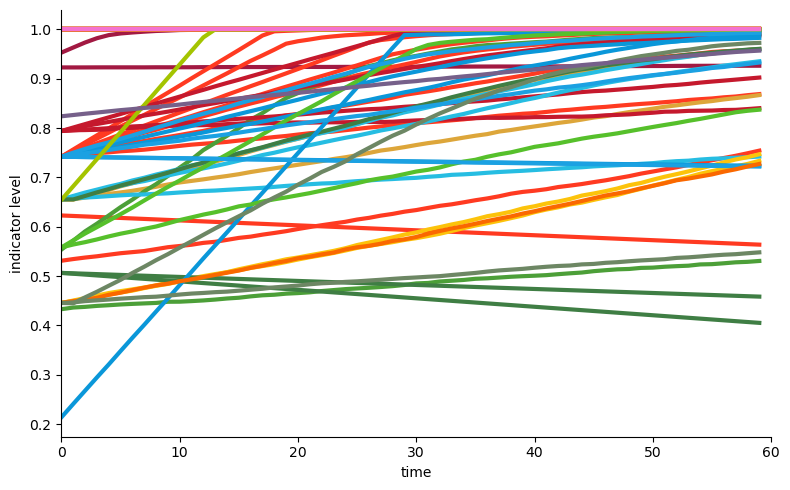

In [16]:
plt.figure(figsize=(8, 5))
for index, row in df_output.iterrows():
    plt.plot(row[range(T)], color=row.color, linewidth=3)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(0,T)
plt.xlabel('time')
plt.ylabel('indicator level')
plt.tight_layout()
plt.savefig("insight/indicator_level_change.png", dpi=300)

Next, we visualise the evolution of the indicators in terms of their change with regards to the initial conditions. Notice how some indicators improve while others worsen. This is useful information to prioritise budgetary interventions.

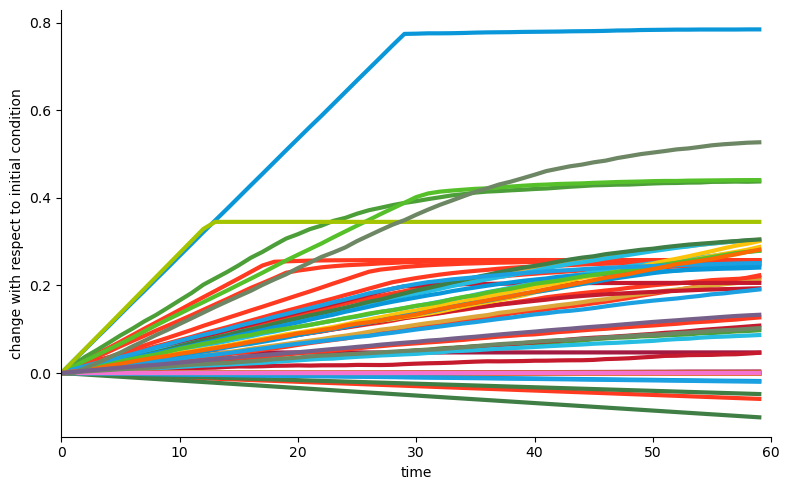

In [17]:
plt.figure(figsize=(8, 5))
for index, row in df_output.iterrows():
    plt.plot(row[range(T)]-row[0], color=row.color, linewidth=3)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(0,T)
plt.xlabel('time')
plt.ylabel('change with respect to initial condition')

plt.tight_layout()
plt.savefig("insight/indicator_change_to_initial_condition.png", dpi=300)


Now, let's display the final values of the indicators and the goals that the government is trying to achieve. The distance between the bars and the dots (the thin line) denote the development gaps that would remain open in 10 years.

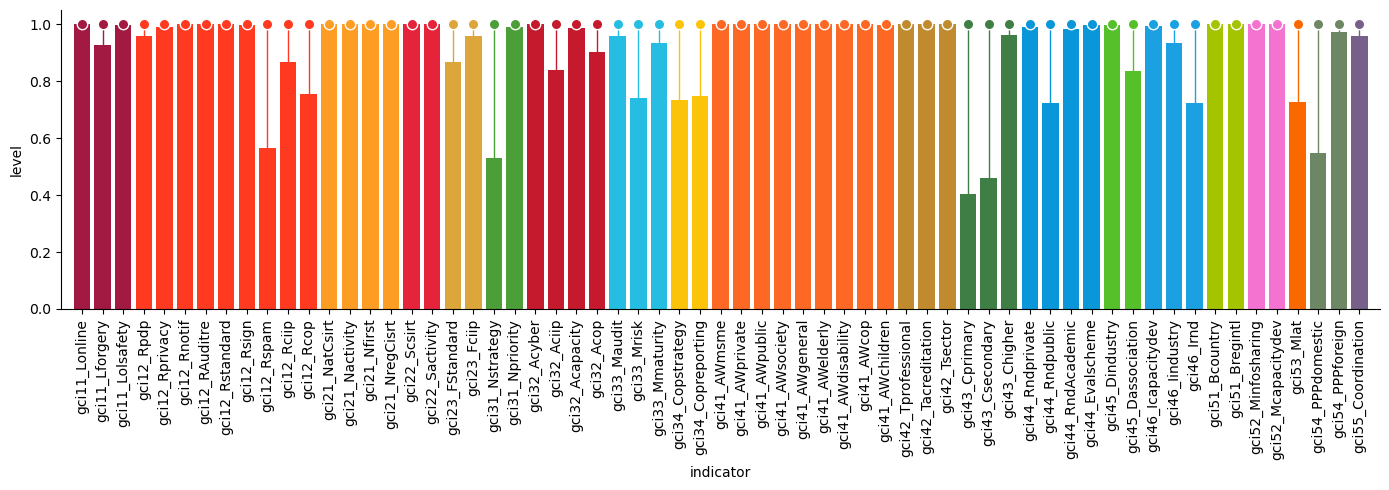

In [18]:
plt.figure(figsize=(14, 5))
for index, row in df_output.iterrows():
    plt.bar(index, row[T-1], color=row.color, linewidth=3)
    plt.plot([index, index], [row[T-1], row.goal], color=row.color, linewidth=1)
    plt.plot(index, row.goal, '.', mec='w', mfc=row.color, markersize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(-1, N)
plt.xticks(range(N))
plt.gca().set_xticklabels(df_output.seriesCode, rotation=90)
plt.xlabel('indicator')
plt.ylabel('level')
plt.tight_layout()
plt.savefig("insight/simulation_predictive_result.png", dpi=300)

In [19]:
df_raw_indi = pd.read_csv('C:/Users/rha005/OneDrive - CSIRO/Documents/7. CSIRO/00. Work in Progress - ON Office/Week 9-10/ppi-gci-main-indicators/tutorials/raw_data'+scenario+'/pre_raw_indicators.csv')
GCIScore  = np.sum(df_output[59].values*df_raw_indi['2024weight'].values)
GCIScore

90.35190942447925

## Simulated intervention

Finally, let me show an example of a simulated intervention through a gradual increase of government expenditure. Let me assume that the government decides to implement linear increments such that, in 10 years, the amount of expenditure triplicates. Here, I show how to implement this intervention through the disbursement schedule and, then how to analyse the difference in development gaps between the baseline prospective and this counterfactual.

In [20]:
# define linear growth coefficients
linear_growth = np.tile(np.linspace(0, 2, T), (Bs_used.shape[0],1))
Bs3 = Bs_used*(1+linear_growth)

outputs = []
for sample in range(sample_size):
    output = ppi.run_ppi(I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
                Imax=Imax, Imin=Imin, Bs=Bs3, B_dict=B_dict_new, T=T, G=goals)
    outputs.append(output)

# separate the outputs into lists of time series
tsI, tsC, tsF, tsP, tsS, tsG = zip(*outputs)

# copmute the average time series of the indicators
tsI_hat = np.mean(tsI, axis=0)

# make a new dataframe with the indicators' information
new_rows = []
for i, serie in enumerate(tsI_hat):
    new_row = [df_indis.iloc[i].seriesCode, df_indis.iloc[i].sdg, df_indis.iloc[i].color] + serie.tolist()
    new_rows.append(new_row)

df_output2 = pd.DataFrame(new_rows, columns=['seriesCode', 'sdg', 'color']+list(range(T)))
df_output2['goal'] = goals

Now we compute the development gaps of the baseline and the counterfactual, and present them in a scatter plot to show which indicators respond to the intervention. If a dot lies below the 45-degree line, it means that the gap reduced due to the budget increment. In this example, we can see that some indicators respond, but the gap reductions are quite modest. In the next tutorial I will show how to use this information in search of structural bottlenecks.

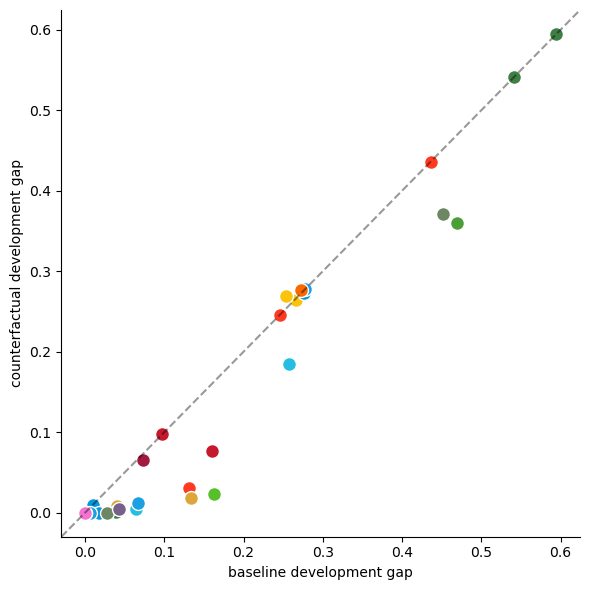

In [21]:
plt.figure(figsize=(6, 6))
for index, row in df_output.iterrows():
    if row.goal > row[T-1]:  # consider only those indicators that would not reach their goals
        plt.plot((row.goal-row[T-1]), (df_output2.iloc[index].goal-df_output2.iloc[index][T-1]),
                 '.', mec='w', mfc=row.color, markersize=20)
# garis x = y transparan
lims = [
    min(plt.xlim()[0], plt.ylim()[0]),  # ambil batas bawah terendah
    max(plt.xlim()[1], plt.ylim()[1])   # ambil batas atas tertinggi
]
plt.plot(lims, lims, linestyle='--', linewidth=1.5, alpha=0.4, color='k')
plt.xlim(lims)
plt.ylim(lims)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('baseline development gap')
plt.ylabel('counterfactual development gap')
plt.tight_layout()
plt.savefig("insight/development_gaps_baseline_vs_counterfactual.png", dpi=300)

In [22]:
df_result_2025 = pd.DataFrame({
    'seriesCode': df_indis['seriesCode'],
    'value_2025': df_output[59]
})

df_result_2025.to_csv('C:/Users/rha005/OneDrive - CSIRO/Documents/7. CSIRO/00. Work in Progress - ON Office/Week 9-10/ppi-gci-main-indicators/tutorials/clean_data'+scenario+'/df_output.csv', index=False)


In [23]:
df_output2

,seriesCode,sdg,color,0,1,2,3,4,5,6,...,51,52,53,54,55,56,57,58,59,goal
0,gci11_Lonline,11,#A21942,0.952941,0.961194,0.970478,0.977537,0.983347,0.987393,0.991357,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,gci11_Lforgery,11,#A21942,0.922925,0.923048,0.923281,0.923442,0.923602,0.923688,0.923701,...,0.932339,0.932609,0.932769,0.932892,0.933237,0.933323,0.933630,0.933938,0.934245,1.0
2,gci11_Lolsafety,11,#A21942,1.000000,0.999949,0.999901,0.999856,0.999812,0.999771,0.999729,...,0.999102,0.999102,0.999081,0.999057,0.999032,0.999065,0.999048,0.999066,0.999042,1.0
3,gci12_Rpdp,12,#FF3A21,0.741936,0.746756,0.750800,0.755399,0.760219,0.764596,0.769749,...,0.993909,0.995009,0.995774,0.996430,0.996540,0.997005,0.997225,0.997564,0.997691,1.0
4,gci12_Rprivacy,12,#FF3A21,0.741936,0.748960,0.755985,0.762574,0.769598,0.777276,0.784410,...,0.999244,0.999457,0.999615,0.999725,0.999831,0.999938,0.999938,0.999933,0.999993,1.0
5,gci12_Rnotif,12,#FF3A21,0.741936,0.756628,0.771320,0.785860,0.800552,0.814785,0.829325,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
6,gci12_RAuditre,12,#FF3A21,0.741936,0.754733,0.767117,0.779776,0.792574,0.805095,0.817893,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
7,gci12_Rstandard,12,#FF3A21,0.741936,0.750543,0.759546,0.767856,0.776562,0.785268,0.793577,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
8,gci12_Rsign,12,#FF3A21,0.741936,0.750625,0.758377,0.766504,0.773600,0.781071,0.789010,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
9,gci12_Rspam,12,#FF3A21,0.622874,0.621872,0.620870,0.619868,0.618866,0.617863,0.616861,...,0.571764,0.570762,0.569760,0.568757,0.567755,0.566753,0.565751,0.564749,0.563747,1.0


In [24]:
# define linear growth coefficients
#linear_growth = np.tile(np.linspace(0, 2, T), (Bs.shape[0], 1))
Bs_retrospective2 = df_exp.drop(columns='seriesCode').values  # shape = (63 x tahun)
BsSelected = np.tile(Bs_retrospective2[:, -1], (T, 1)).T  # shape: (63, T)
#BsSelected = Bs.copy()
rows_to_increase = [3,9,10,11,18,20,27,29,30,43,44,46,47,53,54,59,60]  
rows_to_decrease = [0,4,5,6,8,12,15,16,17,21,22,23,24,26,33,35,40,41,45,49,50,51,52,55,56,57,58,61]
#BsSelected[rows_to_increase, :] *= (1 + linear_growth[rows_to_increase, :])
BsSelected[rows_to_increase, :] += 50000000
BsSelected[rows_to_decrease, :] -= 30357200

used_programs2 = sorted(set(p for v in B_dict.values() for p in v))
BsSelected_used = BsSelected[used_programs2, :]  # shape: (56, T)

print(BsSelected_used)

outputs = []
for sample in range(sample_size):
    output = ppi.run_ppi(I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
                Imax=Imax, Imin=Imin, Bs=BsSelected_used, B_dict=B_dict_new, T=T, G=goals)
    outputs.append(output)

# separate the outputs into lists of time series
tsI, tsC, tsF, tsP, tsS, tsG = zip(*outputs)

# copmute the average time series of the indicators
tsI_hat = np.mean(tsI, axis=0)

# make a new dataframe with the indicators' information
new_rows = []
for i, serie in enumerate(tsI_hat):
    new_row = [df_indis.iloc[i].seriesCode, df_indis.iloc[i].sdg, df_indis.iloc[i].color] + serie.tolist()
    new_rows.append(new_row)

df_output3 = pd.DataFrame(new_rows, columns=['seriesCode', 'sdg', 'color']+list(range(T)))
df_output3['goal'] = goals

[[4.9185298e+09 4.9185298e+09 4.9185298e+09 ... 4.9185298e+09
  4.9185298e+09 4.9185298e+09]
 [3.9000000e+07 3.9000000e+07 3.9000000e+07 ... 3.9000000e+07
  3.9000000e+07 3.9000000e+07]
 [7.9195000e+07 7.9195000e+07 7.9195000e+07 ... 7.9195000e+07
  7.9195000e+07 7.9195000e+07]
 ...
 [3.5798100e+08 3.5798100e+08 3.5798100e+08 ... 3.5798100e+08
  3.5798100e+08 3.5798100e+08]
 [1.6450680e+08 1.6450680e+08 1.6450680e+08 ... 1.6450680e+08
  1.6450680e+08 1.6450680e+08]
 [1.8975820e+09 1.8975820e+09 1.8975820e+09 ... 1.8975820e+09
  1.8975820e+09 1.8975820e+09]]


In [25]:
df_output3

,seriesCode,sdg,color,0,1,2,3,4,5,6,...,51,52,53,54,55,56,57,58,59,goal
0,gci11_Lonline,11,#A21942,0.952941,0.963945,0.974605,0.984207,0.989239,0.993583,0.995620,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,gci11_Lforgery,11,#A21942,0.922925,0.923011,0.923024,0.923110,0.923123,0.923246,0.923259,...,0.927737,0.927787,0.928021,0.928070,0.928120,0.928133,0.928182,0.928232,0.928245,1.0
2,gci11_Lolsafety,11,#A21942,1.000000,0.999949,0.999902,0.999853,0.999806,0.999758,0.999720,...,0.998600,0.998564,0.998532,0.998543,0.998544,0.998548,0.998542,0.998491,0.998459,1.0
3,gci12_Rpdp,12,#FF3A21,0.741936,0.747422,0.752020,0.756952,0.760885,0.764707,0.769306,...,0.946425,0.948543,0.950670,0.952676,0.954132,0.956048,0.957916,0.959172,0.960679,1.0
4,gci12_Rprivacy,12,#FF3A21,0.741936,0.749396,0.755876,0.761920,0.767965,0.774771,0.780162,...,0.976380,0.977308,0.979109,0.980097,0.981350,0.982311,0.983545,0.984514,0.985371,1.0
5,gci12_Rnotif,12,#FF3A21,0.741936,0.756475,0.770862,0.785248,0.799634,0.814021,0.828254,...,0.999994,0.999988,0.999970,0.999964,0.999934,1.000000,0.999988,0.999988,0.999988,1.0
6,gci12_RAuditre,12,#FF3A21,0.741936,0.754595,0.766152,0.777571,0.789128,0.800547,0.811828,...,0.998045,0.998154,0.998324,0.998330,0.998327,0.998444,0.998711,0.998813,0.998861,1.0
7,gci12_Rstandard,12,#FF3A21,0.741936,0.751236,0.759744,0.768153,0.776958,0.785268,0.794072,...,0.995936,0.996313,0.996518,0.996738,0.996928,0.997119,0.997235,0.997332,0.997322,1.0
8,gci12_Rsign,12,#FF3A21,0.741936,0.749407,0.756503,0.763787,0.769946,0.777885,0.784981,...,0.992131,0.993035,0.993626,0.994434,0.995028,0.995339,0.995871,0.996149,0.996400,1.0
9,gci12_Rspam,12,#FF3A21,0.622874,0.641180,0.659486,0.677792,0.695905,0.714211,0.732323,...,1.000000,0.999990,1.000000,1.000000,0.999990,1.000000,0.999990,1.000000,1.000000,1.0


In [26]:
pd.set_option('display.max_rows', None)
combined = pd.DataFrame({
    "indicators": df_output['seriesCode'],
    "original budget": df_output[T-1],
    "after intervention": df_output3[T-1],
    "ratio *": df_output3[T-1]/df_output[T-1]*100,
})
# Print the combined table
combined


,indicators,original budget,after intervention,ratio *
0,gci11_Lonline,1.000000,1.000000,100.000000
1,gci11_Lforgery,0.926367,0.928245,100.202661
2,gci11_Lolsafety,0.998292,0.998459,100.016792
3,gci12_Rpdp,0.960012,0.960679,100.069501
4,gci12_Rprivacy,0.990262,0.985371,99.506119
5,gci12_Rnotif,0.999994,0.999988,99.999400
6,gci12_RAuditre,0.999950,0.998861,99.891095
7,gci12_Rstandard,0.999126,0.997322,99.819479
8,gci12_Rsign,0.997107,0.996400,99.929035
9,gci12_Rspam,0.563747,1.000000,177.384676


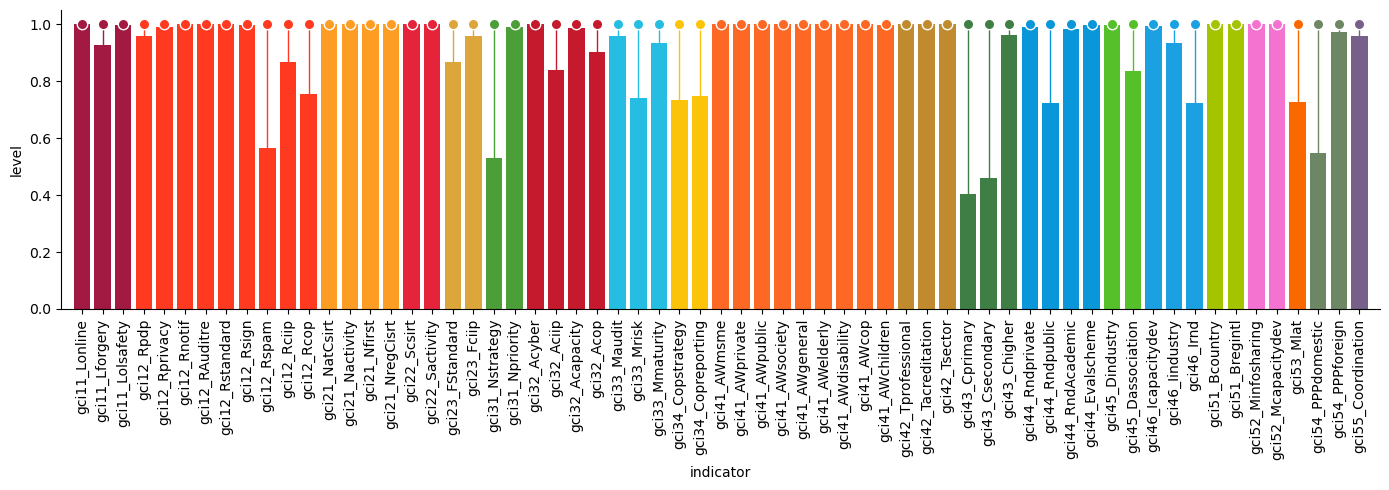

In [27]:
plt.figure(figsize=(14, 5))
for index, row in df_output.iterrows():
    plt.bar(index, row[T-1], color=row.color, linewidth=3)
    plt.plot([index, index], [row[T-1], row.goal], color=row.color, linewidth=1)
    plt.plot(index, row.goal, '.', mec='w', mfc=row.color, markersize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(-1, N)
plt.xticks(range(N))
plt.gca().set_xticklabels(df_output.seriesCode, rotation=90)
plt.xlabel('indicator')
plt.ylabel('level')
plt.tight_layout()

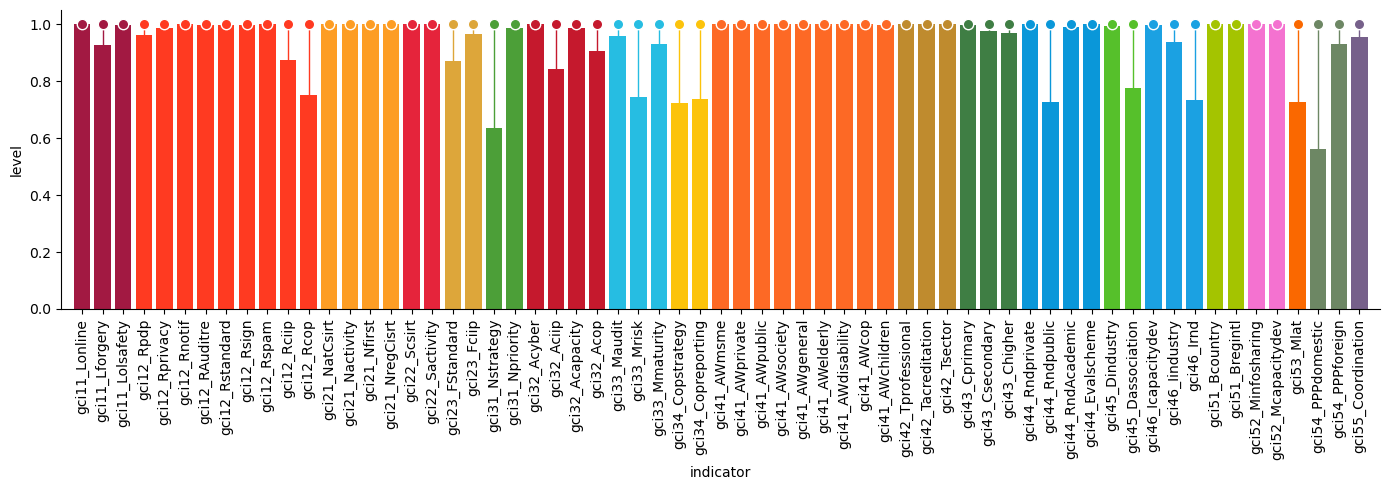

In [28]:
plt.figure(figsize=(14, 5))
for index, row in df_output3.iterrows():
    plt.bar(index, row[T-1], color=row.color, linewidth=3)
    plt.plot([index, index], [row[T-1], row.goal], color=row.color, linewidth=1)
    plt.plot(index, row.goal, '.', mec='w', mfc=row.color, markersize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(-1, N)
plt.xticks(range(N))
plt.gca().set_xticklabels(df_output3.seriesCode, rotation=90)
plt.xlabel('indicator')
plt.ylabel('level')
plt.tight_layout()

In [29]:
GCIScore  = np.sum(df_output3[59].values*df_raw_indi['2024weight'].values)
GCIScore

92.04502447356425

In [30]:
T

60

In [31]:
IF_baseline = df_output[T-1].values
print(df_output[T-1].values[12])
print(IF_baseline[12])

0.9999999650302207
0.9999999650302207


In [32]:
def run_ppi_with_Bs(Bs, model_params, sample_size=100):
    """
    Jalankan PPI sample_size kali dan ambil rata-rata IF final (seperti original PPI).
    """
    sample_size=100
    I0, alphas, alphas_prime, betas, A, R, qm, rl, Imax, Imin, B_dict_full, goals, T_full = model_params
    outputs = []
    for _ in range(sample_size):
        output = ppi.run_ppi(
            I0, alphas, alphas_prime, betas,
            A=A, R=R, qm=qm, rl=rl,
            Imax=Imax, Imin=Imin,
            Bs=Bs, B_dict=B_dict_full, G=goals, T=T_full
        )
        outputs.append(output)

    tsI, *_ = zip(*outputs)
    tsI_hat = np.mean(tsI, axis=0)  # (n, T_full)
    # return IF akhir (last timestep) dari rata-rata simulasi
    return tsI_hat[:, -1]

In [33]:


def find_strict_min_budget_no_if_drop(
    i, Bs_init, model_params, IF_baseline, tol=1e-4, max_iter=30, min_budget=0, verbose=False, if_labels=None
):
    label = if_labels[i] if if_labels is not None else f"ind-{i}"
    baseline = Bs_init[i, 0]
    #IF_baseline = run_ppi_with_Bs(Bs_init, model_params)
    if IF_baseline[i] < 1 - tol:
        # If IF baseline < 1, cannot decrement: keep baseline.
        return baseline

    # Search for minimum budget that keeps IF ~ baseline (decrement, strict)
    low = min_budget
    high = baseline
    min_b = baseline
    for step in range(max_iter):
        mid = (low + high) / 2
        Bs_try = Bs_init.copy()
        Bs_try[i, :] = mid
        IF_try = run_ppi_with_Bs(Bs_try, model_params)[i]
        if verbose:
            print(f"[strict-pool-dec] {label} | budget={mid:.2e}, IF={IF_try:.5f}, baseline IF={IF_baseline[i]:.5f}")
        if IF_try >= IF_baseline[i] - tol:
            min_b = mid
            high = mid
        else:
            low = mid
    return min(min_b, baseline)


def find_min_budget_to_goal_best_effort(
    i, Bs_init, model_params, IF_baseline, goals, tol=1e-4, max_iter=30, min_budget=0, max_budget=None, verbose=False, if_labels=None
):
    baseline = Bs_init[i, 0]
    if max_budget is None:
        max_budget = max(baseline * 10, 1e12)
    Bs_try = Bs_init.copy()
    IF_baseline = run_ppi_with_Bs(Bs_init, model_params)
    label = if_labels[i] if if_labels is not None else f"ind-{i}"
    goal = goals[i]
    best_IF = IF_baseline[i]
    best_budget = baseline
    min_budget_for_goal = None

    low = baseline
    high = max_budget
    step = 0
    while high - low > 1 and step < max_iter:
        mid = (low + high) / 2
        Bs_try[i, :] = mid
        IF_try = run_ppi_with_Bs(Bs_try, model_params)[i]
        if verbose:
            print(f"[best-effort-inc] {label} | budget={mid:.2e}, IF={IF_try:.5f}, goal={goal:.5f}")
        if IF_try >= goal - tol:
            high = mid
            if (min_budget_for_goal is None) or (mid < min_budget_for_goal):
                min_budget_for_goal = mid
        else:
            low = mid
        if IF_try > best_IF:
            best_IF = IF_try
            best_budget = mid
        step += 1
    if min_budget_for_goal is not None:
        return min_budget_for_goal
    if verbose:
        print(f"[WARNING] {label} cannot reach goal, using budget with highest IF={best_IF:.5f} (goal={goal:.5f})")
    return best_budget

def strict_pool_optimization_ready(
    Bs_init, model_params, goals,
    min_subsidi=1e8, tol_gap=1e-4, verbose=True, if_labels=None,
    donor_goal_thresh=0.95
):
    '''
    Pool optimization with full pool conservation and in-place rollback of receiver if IF drops.
    Budget pool is redistributed in loop until exhausted or no eligible receivers remain.
    '''
    Bs = Bs_init.copy()
    n = Bs.shape[0]
    IF_baseline = run_ppi_with_Bs(Bs_init, model_params)
    label = lambda i: if_labels[i] if if_labels is not None else f"ind-{i}"

    budget_min = []
    donor_idx, donor_contrib = [], []
    need_idx, need_amt = [], []
    Bs_baseline = Bs_init.copy()

    # STEP 1: Find minimum budget per indicator (donor/receiver logic)
    pool = 0.0
    for i in range(n):
        if IF_baseline[i] >= donor_goal_thresh:
            if verbose:
                print(f"Indicator: {label(i)} Baseline={IF_baseline[i]:.5f} (donor mode)")
            min_b = find_strict_min_budget_no_if_drop(
                i, Bs_init, model_params, IF_baseline, tol=tol_gap, max_iter=30, verbose=verbose, if_labels=if_labels
            )
        else:
            if verbose:
                print(f"Indicator: {label(i)} Baseline={IF_baseline[i]:.5f} (receiver mode)")
            min_b = find_min_budget_to_goal_best_effort(
                i, Bs_init, model_params, IF_baseline,  goals, tol=tol_gap, max_iter=30, verbose=verbose, if_labels=if_labels
            )
        min_b = max(min_b, min_subsidi[i])
        budget_min.append(min_b)
        if IF_baseline[i] >= donor_goal_thresh and min_b < Bs_init[i,0] - tol_gap:
            donor_idx.append(i)
            donor_contrib.append(Bs_init[i,0] - min_b)
            pool += Bs_init[i,0] - min_b
            if verbose:
                print(f"Donor:    {label(i)} baseline={Bs_init[i,0]:,.0f} min_b={min_b:,.0f} pool_contrib={Bs_init[i,0] - min_b:,.0f}")
        elif IF_baseline[i] < goals[i] - tol_gap and min_b > Bs_init[i,0] + tol_gap:
            need_idx.append(i)
            need_amt.append(min_b - Bs_init[i,0])
            if verbose:
                print(f"Receiver: {label(i)} baseline={Bs_init[i,0]:,.0f} min_b={min_b:,.0f} needs={min_b - Bs_init[i,0]:,.0f}")
        else:
            if verbose:
                print(f"Fixed:    {label(i)} baseline={Bs_init[i,0]:,.0f} min_b={min_b:,.0f}")

    # STEP 2: Set donor to min_b, others as baseline for now
    for idx in donor_idx:
        Bs[idx,:] = budget_min[idx]
    for idx in set(range(n)) - set(donor_idx) - set(need_idx):
        Bs[idx,:] = Bs_init[idx,:]

    # STEP 3: Redistribute pool in loop until pool exhausted or no eligible receiver
    receiver_status = {i: True for i in need_idx}  # eligible receivers
    receiver_delta = dict(zip(need_idx, need_amt))
    pool_left = pool
    n_loop = 0
    while pool_left > 1 and any(receiver_status.values()):
        total_need = sum([amt for i, amt in receiver_delta.items() if receiver_status[i]])
        if total_need < 1e-8:
            break
        if verbose:
            print(f"\n[POOL DISTRIBUTION] Iter {n_loop}, Pool left: {pool_left:,.0f}, Eligible receivers: {sum(receiver_status.values())}")
        changed = False
        for i in need_idx:
            if not receiver_status[i]:
                continue
            alloc = pool_left * (receiver_delta[i] / total_need) if pool_left < total_need else receiver_delta[i]
            Bs[i,:] = Bs_init[i,:] + alloc
            IF_test = run_ppi_with_Bs(Bs, model_params)[i]
            if IF_test >= IF_baseline[i] - tol_gap:
                if verbose:
                    print(f"Pool allocated to {label(i)}: +{alloc:,.0f}, final budget={Bs[i,0]:,.0f} IF={IF_test:.4f}")
                # allocation accepted
                pool_left -= alloc
                receiver_status[i] = False  # done, can't allocate more
                changed = True
            else:
                if verbose:
                    print(f"[ROLLBACK] {label(i)}: IF dropped after allocation! Rolling back allocation.")
                Bs[i,:] = Bs_init[i,:]
                receiver_status[i] = False
                changed = True
        n_loop += 1
        if not changed:
            break

    # STEP 4: Final budget/IF check
    IF_final = run_ppi_with_Bs(Bs, model_params)
    for i in range(n):
        if IF_final[i] < IF_baseline[i] - tol_gap:
            if verbose:
                print(f"[FINAL ROLLBACK] {label(i)} IF dropped at end, restoring to baseline.")
            Bs[i,:] = Bs_init[i,:]
    IF_final = run_ppi_with_Bs(Bs, model_params)

    # Final verbose stats
    if verbose:
        total_base = Bs_init.sum()
        total_opt = Bs.sum()
        print(f"\n[SUMMARY] Total Baseline Budget: {total_base:,.0f}, Total Optimized Budget: {total_opt:,.0f}")
        print(f"Total Pool Used: {pool - pool_left:,.0f}, Pool Left: {pool_left:,.0f}")
        print(f"Total IF Improved (sum): {(IF_final-IF_baseline).sum():.4f}")

    return Bs, IF_final


In [34]:
def visualize_comparison(baseline, optimized, labels,filename, title, ylabel):
    df = pd.DataFrame({
        ylabel + " baseline": baseline,
        ylabel + " optimized": optimized
    }, index=labels)
    df["delta"] = df.iloc[:,1] - df.iloc[:,0]
    # Visualisasi lebih indah
    fig, ax = plt.subplots(figsize=(14,8))
    width = 0.35
    idx = np.arange(len(labels))
    ax.bar(idx - width/2, baseline, width, label='Baseline')
    ax.bar(idx + width/2, optimized, width, label='Optimized')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xticks(idx)
    ax.set_xticklabels(labels, rotation=90, fontsize=9)
    ax.legend()
    plt.tight_layout()
    plt.savefig("insight/"+filename+".png", dpi=300)
    plt.show()

    # Delta heatmap
    fig2, ax2 = plt.subplots(figsize=(14,2))
    delta = df["delta"].values
    cmap = plt.get_cmap("bwr")
    norm = plt.Normalize(delta.min(), delta.max())
    bars = ax2.bar(labels, delta, color=cmap(norm(delta)))
    ax2.set_title("Delta (Optimized - Baseline)")
    ax2.axhline(0, color='k', linewidth=1)
    ax2.set_xticklabels(labels, rotation=90, fontsize=9)
    plt.tight_layout()
    plt.savefig("insight/"+filename+"_delta.png", dpi=300)
    plt.show()
    return df
    
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi

def visualize_budget_if_comparison(
    df_budget, df_IF, 
    top_n=15, 
    sort_by="delta_budget", 
    figsize=(18, 10)
):
    """
    Visualisasi komparasi anggaran & IF (before-after) untuk top_n indikator perubahan terbesar.
    """
    # Merge and prepare
    df_plot = df_budget.merge(
        df_IF, left_index=True, right_index=True, 
        suffixes=('_budget', '_IF')
    )

    # Sorting: top perubahan (positif/negatif)
    key = 'delta_budget' if sort_by == 'delta_budget' else 'delta_IF'
    top = df_plot.reindex(df_plot[key].abs().sort_values(ascending=False).index)[:top_n]
    
    ind = np.arange(len(top))
    width = 0.35

    fig, axs = plt.subplots(2, 2, figsize=figsize, gridspec_kw={'height_ratios':[3,1]})

    # --- Bar: Budget baseline & optimized ---
    axs[0, 0].bar(ind - width/2, top['Budget baseline'], width, label='Baseline', alpha=0.7)
    axs[0, 0].bar(ind + width/2, top['Budget optimized'], width, label='Optimized', alpha=0.7)
    axs[0, 0].set_xticks(ind)
    axs[0, 0].set_xticklabels(top.index, rotation=45, ha='right')
    axs[0, 0].set_title('Top Indicators: Budget Baseline vs Optimized')
    axs[0, 0].set_ylabel('Budget')
    axs[0, 0].legend()

    # --- Bar: IF baseline & optimized ---
    axs[0, 1].bar(ind - width/2, top['IF baseline'], width, label='Baseline', alpha=0.7)
    axs[0, 1].bar(ind + width/2, top['IF optimized'], width, label='Optimized', alpha=0.7)
    axs[0, 1].set_xticks(ind)
    axs[0, 1].set_xticklabels(top.index, rotation=45, ha='right')
    axs[0, 1].set_title('Top Indicators: IF Baseline vs Optimized')
    axs[0, 1].set_ylabel('IF Score')
    axs[0, 1].legend()

    # --- Delta budget ---
    axs[1, 0].barh(ind, top['delta_budget'], color='royalblue', alpha=0.7)
    axs[1, 0].set_yticks(ind)
    axs[1, 0].set_yticklabels(top.index)
    axs[1, 0].set_title('Change in Budget (Optimized - Baseline)')
    axs[1, 0].set_xlabel('Budget Change')

    # --- Delta IF ---
    axs[1, 1].barh(ind, top['delta_IF'], color='orangered', alpha=0.7)
    axs[1, 1].set_yticks(ind)
    axs[1, 1].set_yticklabels(top.index)
    axs[1, 1].set_title('Change in IF Score')
    axs[1, 1].set_xlabel('IF Change')

    plt.tight_layout()
    plt.savefig("insight/Top_indicators_insight.png", dpi=300)
    plt.show()

    # Save summary table as CSV
    df_plot.to_csv("insight/summary_table.csv", index=False)

    # Style and export as PNG (sync, preferred if possible)
    styled = df_plot.style.background_gradient(
        subset=['delta_budget', 'delta_IF'],
        cmap='coolwarm', axis=None
    ).format({'Budget baseline':'{:,.0f}', 'Budget optimized':'{:,.0f}', 'delta_budget':'{:+,.0f}',
          'IF baseline':'{:,.3f}', 'IF optimized':'{:,.3f}', 'delta_IF':'{:+.3f}'})
    # Optionally: display in notebook
    display(styled)

    return top, styled


def heatmap_budget_IF(df_budget, df_IF):
    df_heat = df_budget[["Budget baseline", "Budget optimized"]].join(
        df_IF[["IF baseline", "IF optimized"]])
    fig, ax = plt.subplots(figsize=(10, 16))
    sns.heatmap(df_heat, annot=True, fmt=".2e", cmap="YlGnBu", linewidths=.5, ax=ax)
    plt.title("Baseline vs Optimized: Budget & IF for All Indicators")
    plt.show()

In [35]:
params_dict = {
    "I0": I0,
    "alphas": alphas,
    "alphas_prime": alphas_prime,
    "betas": betas,
    "A": A,
    "R": R,
    "qm": qm,
    "rl": rl,
    "Imax": Imax,
    "Imin": Imin,
    "Bs": Bs,
    "Bs_used": Bs_used,
    "B_dict_": B_dict,
    "B_dict_new": B_dict_new,
    "goals": goals,
    "T_full": T_full
}

print("DEBUG: Checking shape and type for model_params\n" + "-"*45)
for key, val in params_dict.items():
    if hasattr(val, 'shape'):
        print(f"{key:12}: shape={val.shape}, dtype={getattr(val, 'dtype', type(val))}")
    elif isinstance(val, dict):
        print(f"{key:12}: dict, len={len(val)}")
    elif isinstance(val, (list, tuple)):
        print(f"{key:12}: list/tuple, len={len(val)}")
    else:
        print(f"{key:12}: type={type(val)}, value={val}")
print("-"*45)

DEBUG: Checking shape and type for model_params
---------------------------------------------
I0          : shape=(63,), dtype=float64
alphas      : shape=(63,), dtype=float64
alphas_prime: shape=(63,), dtype=float64
betas       : shape=(63,), dtype=float64
A           : shape=(63, 63), dtype=float64
R           : shape=(63,), dtype=int64
qm          : shape=(63,), dtype=float64
rl          : shape=(63,), dtype=float64
Imax        : shape=(63,), dtype=float64
Imin        : shape=(63,), dtype=float64
Bs          : shape=(63, 60), dtype=float64
Bs_used     : shape=(57, 60), dtype=float64
B_dict_     : dict, len=57
B_dict_new  : dict, len=57
goals       : shape=(63,), dtype=float64
T_full      : type=<class 'int'>, value=60
---------------------------------------------


In [36]:
# Siapkan data awal
# Bs_init = matriks anggaran baseline [n,T]
# model_params = tuple semua parameter PPI (semua indikator)
# label_indikator = list kode/nama indikator (len=n)
# goals = array goals tiap indikator


total_baseline = Bs[:,0].sum()
min_subsidi = [max(0.0002 * total_baseline, Bs[i,0]/5) for i in range(Bs.shape[0])]
model_params = (I0, alphas, alphas_prime, betas, A, R_full, qm, rl, Imax, Imin, B_dict_full, goals, T_full)
instrumental_indices = np.where(R)[0]     # len = 57
if_labels = df_indis['seriesCode'].values


Bs_opt, IF_opt = strict_pool_optimization_ready(
    Bs_init=Bs,
    model_params=model_params,
    goals=goals,
    min_subsidi=min_subsidi,
    tol_gap=1e-4,
    verbose=True,
    if_labels=if_labels,
    donor_goal_thresh=0.95  # IF baseline minimal untuk dianggap donatur, bisa diubah ke 1.0 jika ingin super strict
)

Indicator: gci11_Lonline Baseline=1.00000 (donor mode)
[strict-pool-dec] gci11_Lonline | budget=2.47e+09, IF=1.00000, baseline IF=1.00000
[strict-pool-dec] gci11_Lonline | budget=1.24e+09, IF=0.99962, baseline IF=1.00000
[strict-pool-dec] gci11_Lonline | budget=1.86e+09, IF=1.00000, baseline IF=1.00000
[strict-pool-dec] gci11_Lonline | budget=1.55e+09, IF=0.99970, baseline IF=1.00000
[strict-pool-dec] gci11_Lonline | budget=1.70e+09, IF=0.99987, baseline IF=1.00000
[strict-pool-dec] gci11_Lonline | budget=1.78e+09, IF=1.00000, baseline IF=1.00000
[strict-pool-dec] gci11_Lonline | budget=1.74e+09, IF=1.00000, baseline IF=1.00000
[strict-pool-dec] gci11_Lonline | budget=1.72e+09, IF=0.99987, baseline IF=1.00000
[strict-pool-dec] gci11_Lonline | budget=1.73e+09, IF=1.00000, baseline IF=1.00000
[strict-pool-dec] gci11_Lonline | budget=1.73e+09, IF=0.99987, baseline IF=1.00000
[strict-pool-dec] gci11_Lonline | budget=1.73e+09, IF=0.99975, baseline IF=1.00000
[strict-pool-dec] gci11_Lonline 

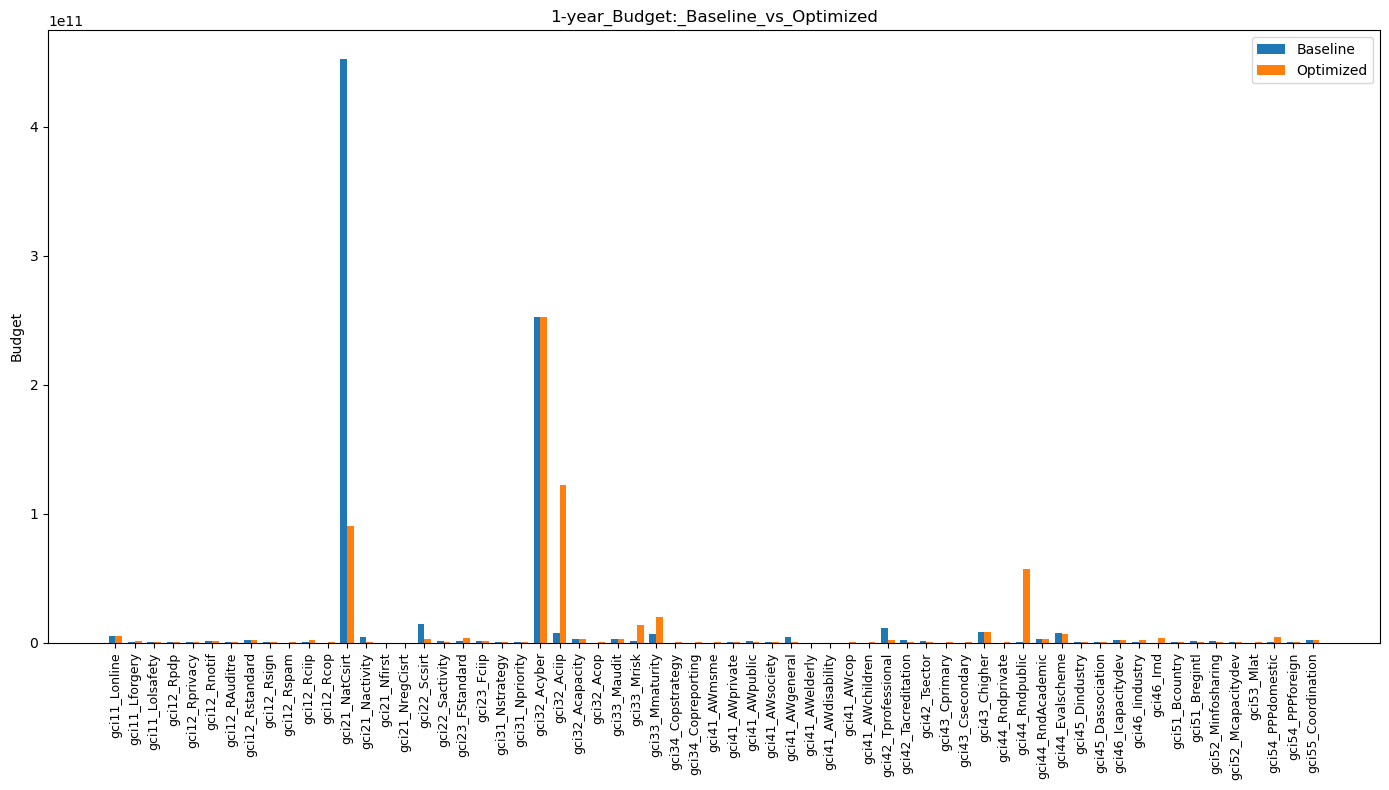

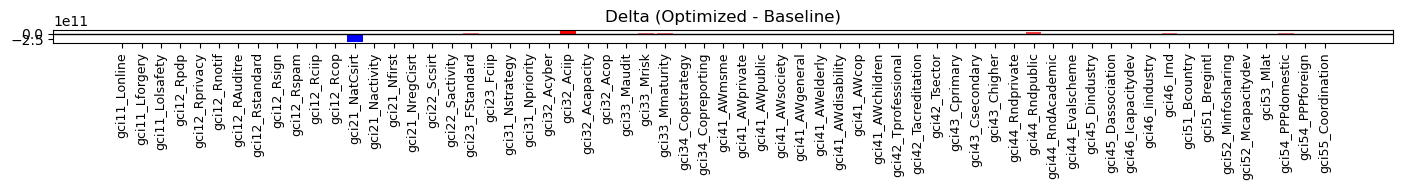

In [54]:
# --- EVALUASI/OUTPUT ---
# Bandingkan budget baseline vs optimized
label_indikator = df_indis['seriesCode'].values
df_budget = visualize_comparison(
    Bs[:,0], Bs_opt[:,0], label_indikator, filename="Budget_optimization",
    title="1-year_Budget:_Baseline_vs_Optimized", ylabel="Budget"
)


(63,)


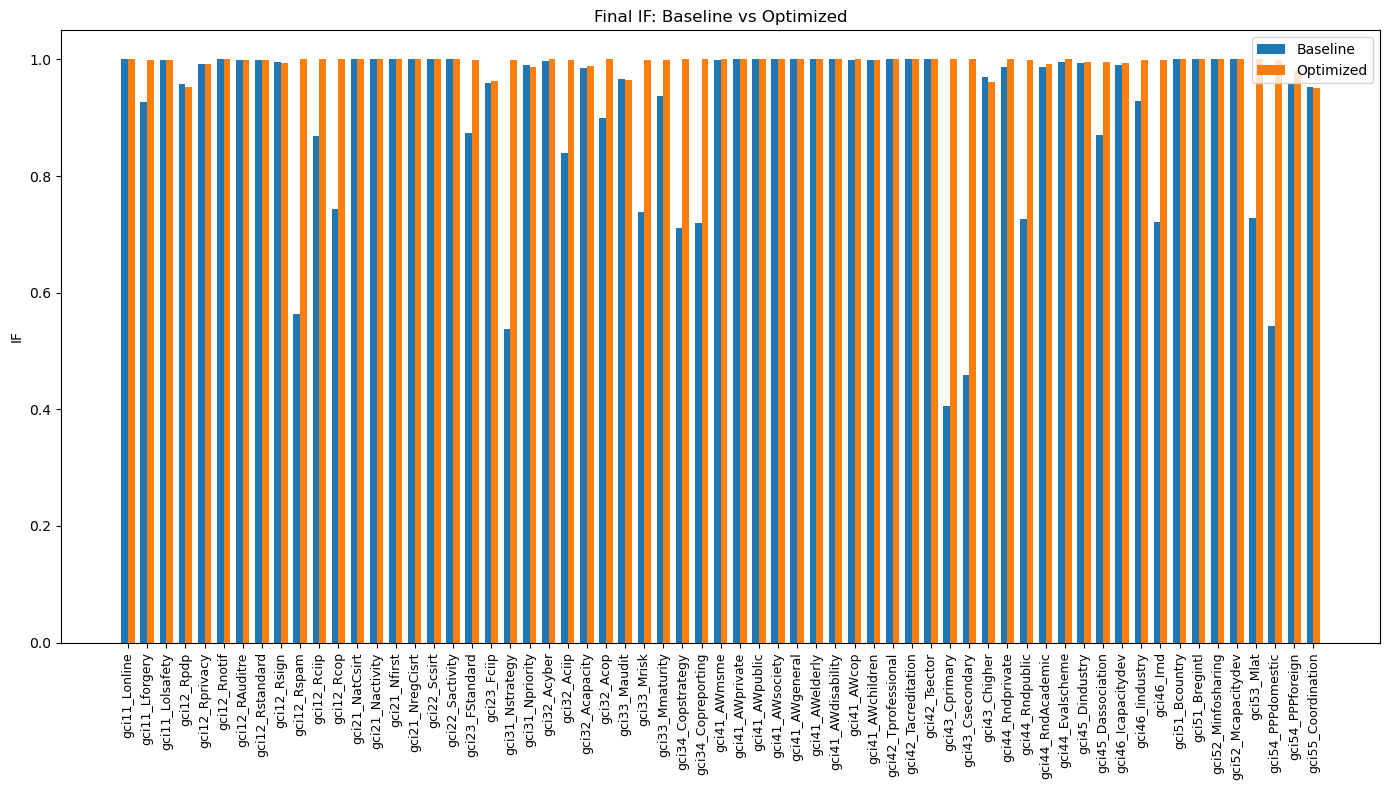

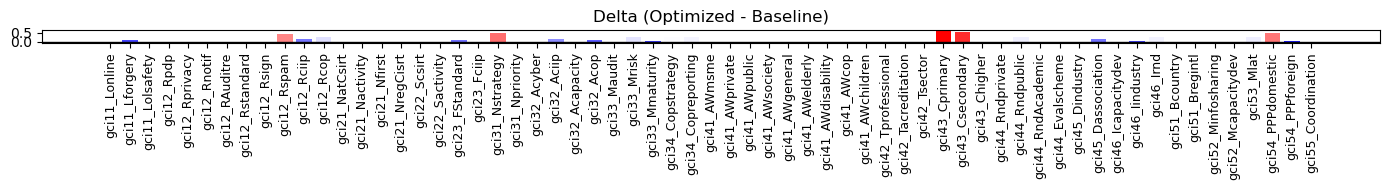

In [38]:
# Bandingkan IF baseline vs optimized
IF_baseline = run_ppi_with_Bs(Bs, model_params)
label_indikator = df_indis['seriesCode'].values
print(IF_opt.shape)
df_IF = visualize_comparison(
    IF_baseline, IF_opt, label_indikator, filename="IF_optimization",
    title="Final IF: Baseline vs Optimized", ylabel="IF"
)



In [39]:

# Lihat tabel hasil
print(df_budget)
print(df_IF)

                     Budget baseline  Budget optimized         delta
gci11_Lonline           4.948887e+09      4.948887e+09  0.000000e+00
gci11_Lforgery          3.900000e+07      8.591261e+08  8.201261e+08
gci11_Lolsafety         7.919500e+07      1.606958e+08  8.150077e+07
gci12_Rpdp              4.629170e+08      4.629170e+08  0.000000e+00
gci12_Rprivacy          4.865300e+08      4.865300e+08  0.000000e+00
gci12_Rnotif            8.154980e+08      8.154980e+08  0.000000e+00
gci12_RAuditre          5.617200e+08      5.617200e+08  0.000000e+00
gci12_Rstandard         2.330601e+09      2.330601e+09  0.000000e+00
gci12_Rsign             4.389090e+08      4.389090e+08  0.000000e+00
gci12_Rspam             1.000000e-12      1.606958e+08  1.606958e+08
gci12_Rciip             3.305220e+08      1.868772e+09  1.538250e+09
gci12_Rcop              1.000000e-12      1.606958e+08  1.606958e+08
gci21_NatCsirt          4.520000e+11      9.040000e+10 -3.616000e+11
gci21_Nactivity         3.911248e+

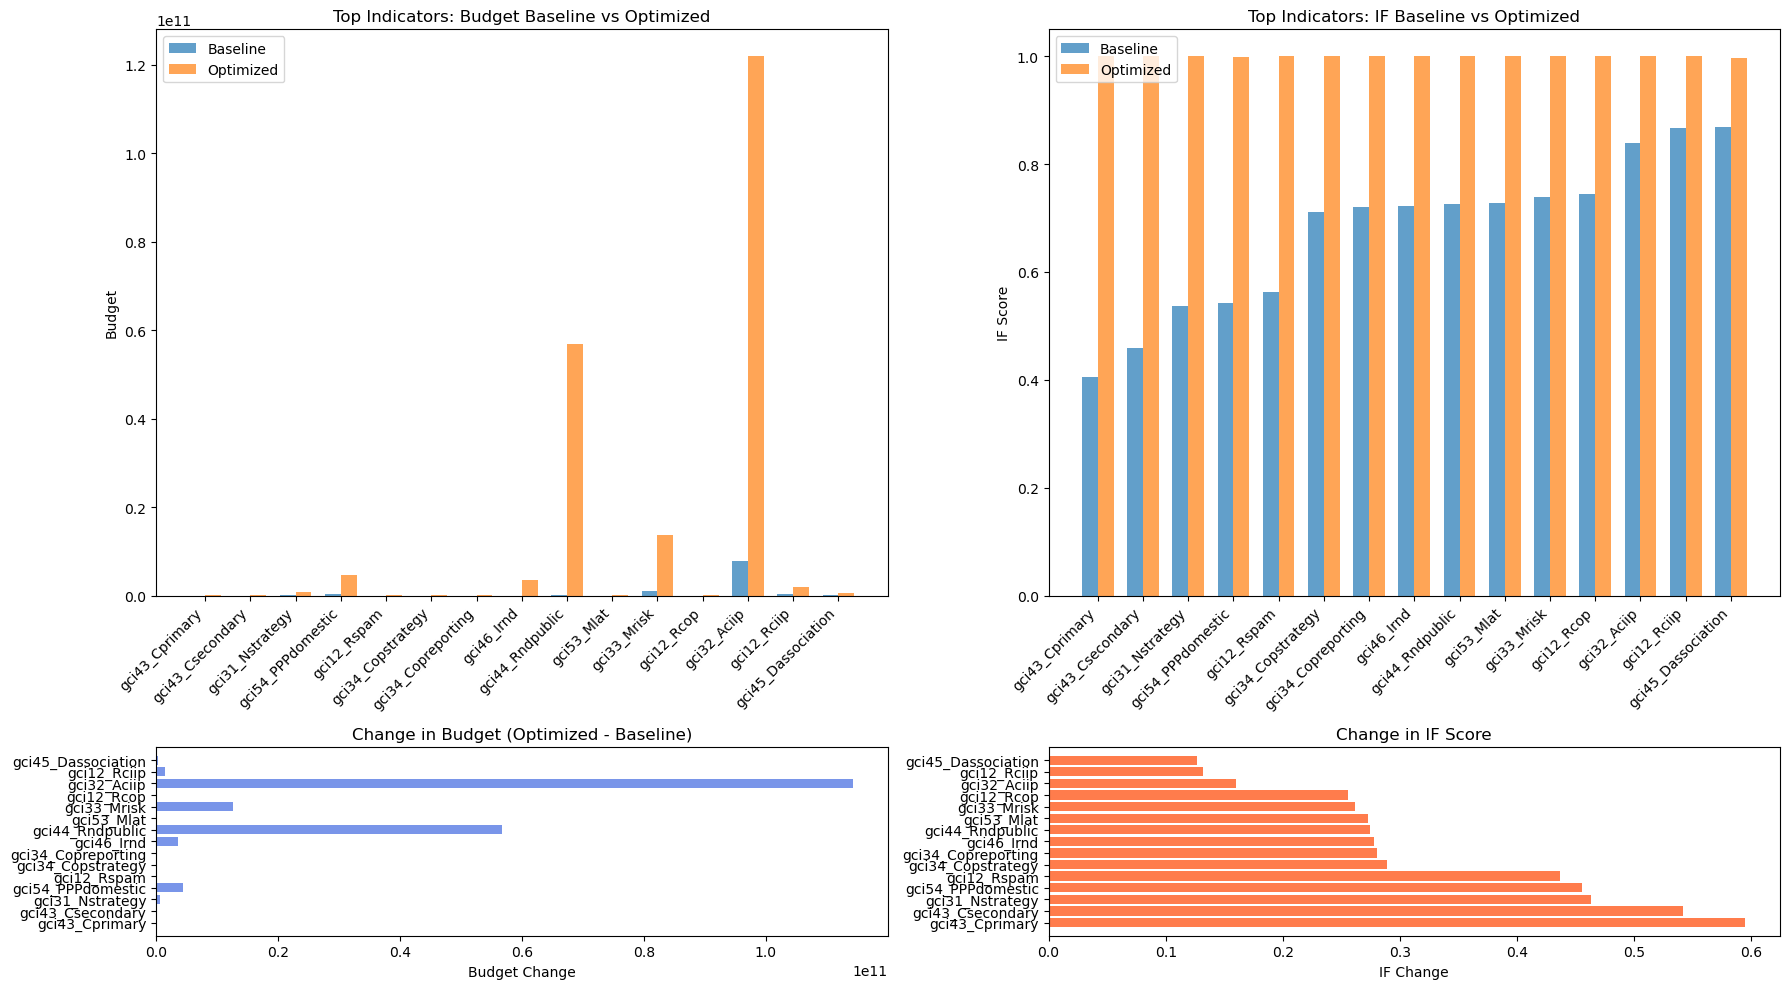

,Budget baseline,Budget optimized,delta_budget,IF baseline,IF optimized,delta_IF
gci11_Lonline,"4,948,887,000","4,948,887,000",+0,1.000,1.000,-0.000
gci11_Lforgery,"39,000,000","859,126,063","+820,126,063",0.927,1.000,+0.072
gci11_Lolsafety,"79,195,000","160,695,766","+81,500,766",0.998,0.999,+0.001
gci12_Rpdp,"462,917,000","462,917,000",+0,0.959,0.953,-0.006
gci12_Rprivacy,"486,530,000","486,530,000",+0,0.993,0.992,-0.000
gci12_Rnotif,"815,498,000","815,498,000",+0,1.000,1.000,+0.000
gci12_RAuditre,"561,720,000","561,720,000",+0,0.999,1.000,+0.001
gci12_Rstandard,"2,330,601,000","2,330,601,000",+0,1.000,0.999,-0.001
gci12_Rsign,"438,909,000","438,909,000",+0,0.995,0.995,-0.000
gci12_Rspam,0,"160,695,766","+160,695,766",0.564,1.000,+0.436


In [40]:

instrumental_indices = np.where(R)[0]     # len = 57
label_indikator = df_indis['seriesCode'].values

df_budget = df_budget.rename(columns={"delta":"delta_budget"})
df_IF = df_IF.rename(columns={"delta":"delta_IF"})

top_indikator, styled = visualize_budget_if_comparison(df_budget, df_IF, top_n=15, sort_by="delta_IF")

async def export_styled_df():
    await dfi.export_async(styled, "insight/Budget_Optimization_Summary_Table.png")

await export_styled_df()

In [41]:
df_budget.to_csv('insight/df_Budget_after_optimazion.csv', index=False)
df_IF.to_csv('insight/df_IF_after_optimazion.csv', index=False)

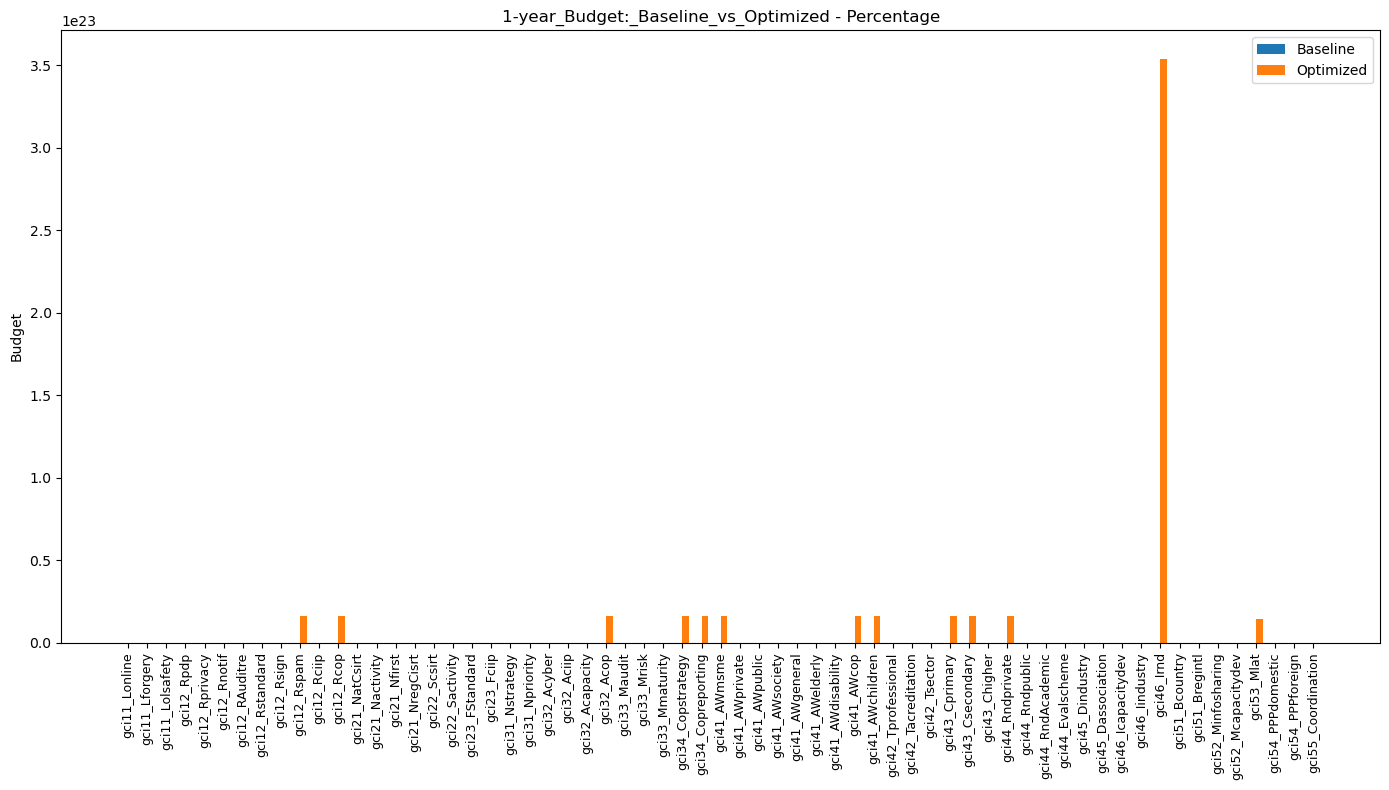

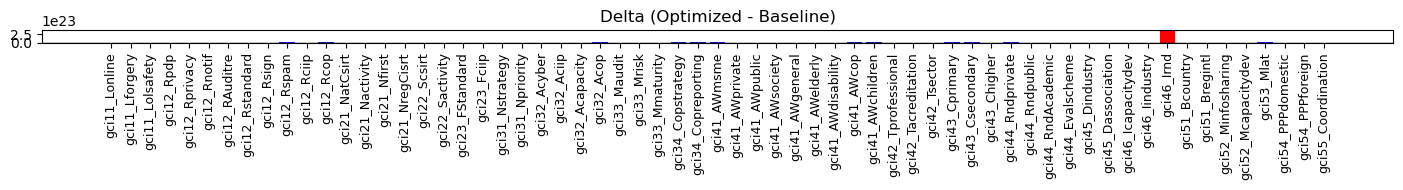

In [55]:
# --- EVALUASI/OUTPUT ---
Bs[Bs == 0] = 1e-12
Bs_opt[Bs_opt == 0] = 1e-12
P_opt = Bs_opt[:,0]/Bs[:,0]*100
P_bs = Bs[:,0]/Bs[:,0]*100
df_budget = visualize_comparison(
    P_bs, P_opt, label_indikator, filename="Budget_optimizationP_persentage",
    title="1-year_Budget:_Baseline_vs_Optimized - Percentage", ylabel="Budget"
)
